# Remodeling Ethylene Reactor using a different model

### RK4 is employed once again to model the ethylene reactor with a more accurate reaction model taking into account the heat capacity.

In [1]:
# Import libraries
import numpy as np
from numpy import *
import matplotlib.pyplot as plt
plt.style.use('seaborn-white')

In [2]:
#Step size and total number of iterations
s = 0.1
length = 95
z = arange(0,length+s,s)   # Adjust step vector since python rounds down
S = len(z)                 # Total iterations

# Parameters
d = 10.0/100;
r = d/2
R_g = 8.3145
A_c = math.pi*r**2

In [3]:
# Import parameters to model heat capacity (C_p)
# Use DIPPR values for viscosity data. Order for values is [E,Y,H,P,M,L,A,B,W]
A = [2.5906E-07, 2.0789E-06, 1.797E-07, 4.9054E-08, 5.2546E-07, 7.3919E-07, 1.2025E-06, 2.696E-07, 1.7096e-8]
B = [0.67988, 0.4163, 0.685, 0.90125, 0.59006, 0.5423, 0.4952, 0.6715, 1.1146]
C = [98.902, 352.7, -0.59, 0, 105.67, 263.73, 291.4, 134.7, 0]
D = [0, 0, 140, 0, 0, 0, 0, 0, 0]

# Also turn molecular weights into an array (in order of E,Y,H,P,M,L,A,B,W)
MW = [30.069, 28.0532, 2.01588, 44.0956, 16.0425, 42.0797, 26.0373, 54.0904, 18.01528]

# Use DIPPR values for C_p data into arrays. Order for values is [E,Y,H,P,M,L,A,B,W]
CP_A = [44256, 33380, 64979, 59474, 33298, 43852, 36921, 50950, 33363]
CP_B=[84737, 94790, -788.17, 126610, 79933, 150600, 31793, 170500, 26790]
CP_C = [872.24, 1596, 5.8287, 844.31, 2086.9, 1398.8, 678.05, 1532.4, 2610.5]
CP_D = [67130, 55100, -0.018459, 86165, 41602, 74754, 33430, 133700, 8896]
CP_E = [2430.4, 740.8, 0.00002164, 2482.7, 991.96, 616.46, 3036.6, 685.6, 1169]

In [5]:
# Calculate average heat capacity (C_P) using DIPPR data
def C_p(N,T):
  Flux_sum = sum(N)
  mol_frac = N/float(Flux_sum)
  m_tot = dot(mol_frac,MW)  # Dot product of mol fraction and molecular weights gives total mass
  Value = 0
  for i in range(len(N)):
    C_pi = float(CP_A[i] + CP_B[i]*(CP_C[i]/(T*math.sinh(CP_C[i]/T)))**2 + CP_D[i]*(CP_E[i]/(T*math.cosh(CP_E[i]/T)))**2)
    w_i = float(mol_frac[i]*MW[i])/m_tot                  # Mass fraction of i
    Value += w_i * C_pi
  return(Value)

# Find average viscosities according to Graham's model since Herning and Zipperer assume low Hydrogen. [1]
def mu(N,T):
  Flux_sum = sum(N)
  mol_frac = N/float(Flux_sum)
  m_tot = dot(mol_frac,MW)  # Dot product of mol fraction and molecular weights gives total mass
  Value = 0
  for i in range(len(N)):                                 # Loop to find sum 
    mu_i = float(A[i]*T**B[i]/(1+(C[i]/T)+(D[i]/T**2)))   # Viscosity of componenent i						 
    w_i = float(mol_frac[i]*MW[i])/m_tot									# Mass fraction of i∫
    Value += w_i * mu_i
  return(Value)

In [6]:
# Determine rate constants by temperature
K1f = lambda x: (4.652e13)*math.exp(-32811.73924/x)
K1r = lambda x: ((8.75e8)/1000)*math.exp(-16456.19437/x)  # convert k0 from kmol to mol
K2  = lambda x: (3.850e11)*math.exp(-32836.90161/x)
K5f = lambda x: (9.814e8)*math.exp(-18579.89897/x)
K5r = lambda x: ((5.87e4)/1000)*math.exp(-3544.372384/x)
K6  = lambda x: ((1.026e12)/1000)*math.exp(-20763.99326/x)
K8  = lambda x: ((7.083e13)/1000)*math.exp(-30411.2485/x)


In [7]:
# Rate Equations will be an array: We input all fluxes as a vector N, along with velocity and temperature
# This method keeps rendundant inputs (like propane and 1,3 butadiene), but makes calculations easier
# indices [0,1,2,3,4,5,6,7,8] correspond to [E,Y,H,P,M,L,A,B]

R = lambda N,v,T: array([
-K1f(T)*(N[0]/v) + K1r(T)*N[1]*N[2]/(v**2) - 2*K2(T)*(N[0]/v) - K8(T)*N[1]*N[0]/(v**2),           # Ethane
 K1f(T)*(N[0]/v) - K1r(T)*N[1]*N[2]/(v**2) - K6(T)*N[6]*N[1]/(v**2) - K8(T)*N[1]*N[0]/(v**2),     # Ethylene
 K1f(T)*(N[0]/v) - K1r(T)*N[1]*N[2]/(v**2),                                                       # Hydrogen
 K2(T)*(N[0]/v),                                                                                  # Propane
 K2(T)*(N[0]/v) + K5f(T)*(N[5]/v) - K5r(T)*N[6]*N[4]/(v**2) + K8(T)*N[1]*N[0]/(v**2),             # Methane
-K5f(T)*(N[5]/v) + K5r(T)*N[6]*N[4]/(v**2) + K8(T)*N[1]*N[0]/(v**2),                              # Propylene
 K5f(T)*(N[5]/v) - K5r(T)*N[6]*N[4]/(v**2) - K6(T)*N[6]*N[1]/(v**2),                              # Acetylene
 K6(T)*N[6]*N[1]/(v**2),                                                                          # Butane
 0])

In [8]:
# Set entering fluxes for E, Y, and W 
N, N_t = zeros(9), zeros((S,9))   # Flux Vector and Flux Matrix
N[0], N[1], N[8] = 99/A_c, 1/A_c, (66+float(2)/3)/A_c
N_t[0,:] = N

# Initialize pressure
P = zeros(S)
P[0] = 11*101325.0    # Initial pressure is 11 atm 

# Set temperature
T = 820+273.15        # T = 820 C initially

In [9]:
# RK4/Euler Loop
for i in range(S-1):
    v = R_g*T*sum(N)/P[i]
    mu_av = mu(N,T)

    k1 = s*R(N,v,T)                             # Sets k1 for all reaction odes
    k2 = s*R(N+0.5*k1, v, T)                    # Sets k2 for all reaction odes
    k3 = s*R(N+0.5*k2, v, T)                    # Sets k3 for all reaction odes
    k4 = s*R(N+k3, v, T)                        # Sets k4 for all reaction odes

    N += (k1 + 2*k2 + 2*k3 + k4)/6                    # RK4 iteration step
    N_t[i+1,:] = N                                    # Store fluxes to matrix as new row 
                                                      # Columns will be componenents: E,Y,H,P,M,L,A,B,W
    P[i+1] = P[i] - s*(309.66176*(mu_av)**0.25)*v     # Euler method iteration step

In [10]:
# Selectivity and Conversion Calculation
N_final = N_t[S-1,:]
products = sum(N_final) - N_final[0]- N_final[8] - N_t[0,1]  # Subtract ethane, steam, and initial ethylene to find total products of rxn
S_y = (N_final[1]- N_t[0,1])/products                        # Selectivity of ethylene will be total Y produced divided by products
Conv = 1 - N_final[0]/N_t[0,0]                               # Conversion = 1 - Cf/C0 = 1 - Nf/N0 since Ac is constant
print("The selectivity of ethylene is",round(100*S_y,2),"%")
print('Conversion of ethane is ',round(100*Conv,2),'%')

# Create Matrix of values for mole fractions to plot
Y_t = zeros((S,9))
for i in range(S):            
  N_tot = sum(N_t[i,:])
  Y_t[i,:] = N_t[i,:]/N_tot   

The selectivity of ethylene is 23.7 %
Conversion of ethane is  64.2 %


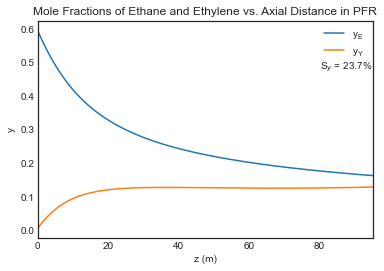

In [11]:
# Plotting 
disp = 'S$_y$ = '+ str(round(100*S_y,2)) + '%'
plt.figure(1)
plt.plot(z, Y_t[:,0], label="$\mathregular{y_E}$")
plt.plot(z, Y_t[:,1], label="$\mathregular{y_Y}$")
plt.xlim(0,length)
plt.text(80,0.48,disp)
plt.legend(loc="upper right")
plt.xlabel("z (m)")
plt.ylabel("y")
plt.title('Mole Fractions of Ethane and Ethylene vs. Axial Distance in PFR')
plt.show()   